# Импорт библиотек

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist 
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image
import numpy as np  
import pandas as pd 
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

import os 
from google.colab import drive 
import time, random
import seaborn as sns
sns.set_style('darkgrid') 

# Подключение к Гугл Диску

In [ ]:
drive.mount('/content/drive/')  

Mounted at /content/drive/


# Вспомогательные функции

## Функция создания автокодировщика

In [ ]:
def baseAutoencoder(shape=(112,80,1)): 
    img_input = Input((shape)) 

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    z = MaxPooling2D()(x) 
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) 
    x = BatchNormalization()(x) 
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
     
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error')

    return model

## Функция вывода изображений

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)): 
  n = 5 
  plt.figure(figsize=(14, 7)) 
  for i in range(n): 
      index = np.random.randint(0, pred.shape[0]) 
 
      ax = plt.subplot(2, n, i + 1) 
      plt.imshow(xTrain[index].reshape(shape)) 
      plt.gray() 
      ax.get_xaxis().set_visible(False)  
      ax.get_yaxis().set_visible(False) 
 
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.imshow(pred[index].reshape(shape))   
      plt.gray() 
      ax.get_xaxis().set_visible(False) 
      ax.get_yaxis().set_visible(False) 
  plt.show()

## Функция получения средней квадратичной ошибки

In [ ]:
def getMSE(x1, x2): 
  x1 = x1.flatten() 
  x2 = x2.flatten() 
  delta = x1 - x2 
  return sum(delta ** 2) / len(delta) 

In [ ]:
x1 = np.array([1, 1, 1]) 
x2 = np.array([1, 1, 1]) 
print(getMSE(x1,x2))

0.0


## Функция создания шума

In [ ]:
def addNoise(x, noiseVal):
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape)
  
  return np.clip(x + noiseVal * noise, 0., 1.) 

## Функция для загрузки изображений

In [ ]:
def load_images(images_dir, img_height, img_width): 
  list_images = []
  for img in os.listdir(images_dir):
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) 

## Функция автокодировщика для подавления шума

In [ ]:
def denoiseAutoencoder(level=1):

  if level not in [1, 2, 3]:
    level = 1

  img_input = Input((112,80,1))

  if level == 1:
    

    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    z = Dense(256, activation='relu')(x)
    x = Dense(7*5*256, activation='relu')(z)
    x = Reshape((7,5,256))(x)
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)

  if level == 2:

    x = Conv2D(16, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    z = Dense(128, activation='relu')(x)
    x = Dense(7*5*128, activation='relu')(z)
    x = Reshape((7,5,128))(x)
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(16, (3, 3), strides=2, padding='same')(x)

  if level == 3:
    x = Conv2D(8, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(16, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    z = Dense(64, activation='relu')(x)
    x = Dense(7*5*64, activation='relu')(z)
    x = Reshape((7,5,64))(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(16, (3, 3), strides=2, padding='same')(x)
    x = Conv2DTranspose(8, (3, 3), strides=2, padding='same')(x)

  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  model = Model(img_input, x)
  model.compile(optimizer='adam',
                loss='mse')
  model.summary()

  return model

# Автокодировщики для подавления шума

## Загрузка базы лиц

In [ ]:
!unzip -q '/content/drive/MyDrive/Lessons/Lesson9/facez.zip' -d "/content/facez"

In [ ]:
images_dir = '/content/facez'
img_height = 112
img_width = 80

In [ ]:
a = load_images(images_dir, img_height, img_width)

In [ ]:
cur_time = time.time()
xTrain_imag = load_images(images_dir, img_height, img_width)
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')

Время загрузки: 38.69с


In [ ]:
xTrain_img = xTrain_imag/255

In [ ]:
xTrain_img.shape

(5018, 112, 80, 1)

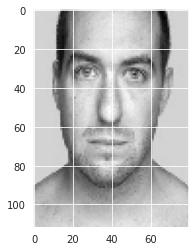

In [ ]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(112,80), cmap='gray')
plt.show()

## Второй автокодировщик для подавления шума

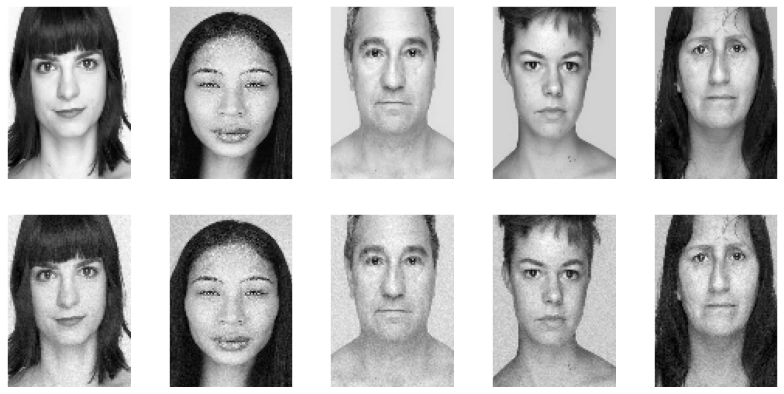

In [ ]:
noisedXTrainFace = addNoise(xTrain_img, 0.05)
plotImages(xTrain_img, noisedXTrainFace)

In [ ]:
modelDenoiseFace = denoiseAutoencoder(level=2)

modelDenoiseFace.fit(xTrain_img[:4700], xTrain_img[:4700], epochs=50, batch_size=100, validation_data = (noisedXTrainFace[4700:], xTrain_img[4700:]))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 80, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 40, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 20, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 5, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 4480)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               573568

In [ ]:
predFaceDenoise = modelDenoiseFace.predict(noisedXTrainFace[:4000]) 
predFaceDenoise = predFaceDenoise * 255   
predFaceDenoise = predFaceDenoise.astype('uint8')

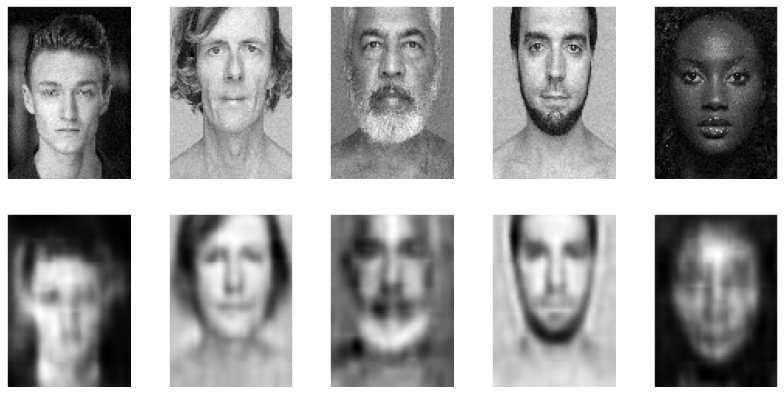

In [ ]:
plotImages(noisedXTrainFace, predFaceDenoise)

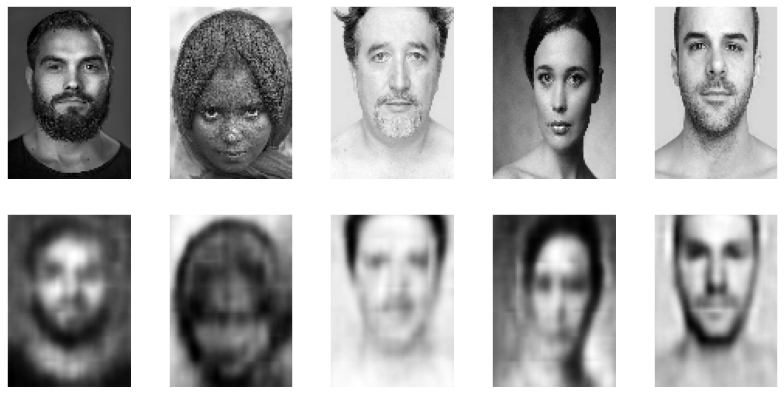

In [ ]:
plotImages(xTrain_img, predFaceDenoise)

In [ ]:
errFace = [getMSE(xTrain_img[i], predFaceDenoise[i] / 255) for i in range(len(predFaceDenoise))]
print("Средняя ошибка на Лицах:", round(sum(errFace) / len(errFace), 4))
print("Минимальная ошибка на Лицах:", round(min(errFace),4))

Средняя ошибка на Лицах: 0.0066
Минимальная ошибка на Лицах: 0.0014


In [ ]:
del modelDenoiseFace